# This notebook

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter
import seaborn as sns, numpy as np
import json
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from scipy.optimize import minimize
from scipy import sparse
import statsmodels.base.model as base
from statsmodels.iolib import summary2
from statsmodels.genmod import families
from statsmodels.genmod import bayes_mixed_glm
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM, BinomialBayesMixedGLM 
from math import sqrt

/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [10]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [48]:
data_new=pd.read_csv('data/data_new.csv')
data_new.drop(columns=['SIM1_fitted','SIM_attr1_fitted','SIM_prod1_fitted'], inplace=True)

In [49]:
data_new

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,orig_y,dest_x,dest_y,dest_centroid,dest_flr_sq_ft,dest_ID2,distance_m
0,0,1,222-222@5pw-2r3-nwk,1,60613,4586.2225,"c(-87.6600560482455, 41.9544446976887)",48281,198630,-87.660056,41.954445,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,30116.392390
1,168,1,222-222@5pw-2r3-nwk,2,60620,8718.3984,"c(-87.6534303384955, 41.7395695585666)",72216,58886,-87.653430,41.739570,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,6260.906290
2,325,1,222-222@5pw-2r3-nwk,3,60621,4686.3120,"c(-87.6398183374013, 41.7759832343989)",35912,40393,-87.639818,41.775983,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,10255.728250
3,457,1,222-222@5pw-2r3-nwk,4,60623,6174.1133,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,41.848458,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,19293.265720
4,627,1,222-222@5pw-2r3-nwk,5,60628,64853.7564,"c(-87.6143668946616, 41.6916879141685)",72202,69223,-87.614367,41.691688,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,2556.211231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,5731,267,zzy-224@5pw-624-bx5,40,60661,199.0023,"c(-87.6435718715846, 41.8828721110736)",7792,188552,-87.643572,41.882872,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,718.612796
8573,6800,267,zzy-224@5pw-624-bx5,50,60649,573.0814,"c(-87.5702279631487, 41.7631483688459)",46650,73738,-87.570228,41.763148,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,14715.698530
8574,6896,267,zzy-224@5pw-624-bx5,51,60601,1109.0254,"c(-87.6210216917246, 41.8864044467238)",11110,263534,-87.621022,41.886404,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,1247.347600
8575,7229,267,zzy-224@5pw-624-bx5,54,60629,679.1327,"c(-87.7127518885735, 41.7751962066305)",113916,65458,-87.712752,41.775196,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,13867.786240


In [42]:
data_new['log_dest_flr_sq_ft']=np.log(data_new['dest_flr_sq_ft'])
data_new['log_distance_m']=np.log(data_new['distance_m'])
data_new['log_orig_pop']=np.log(data_new['orig_pop'])
data_new['log_orig_family_income']=np.log(data_new['orig_family_income'])
data_new

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,dest_x,dest_y,dest_centroid,dest_flr_sq_ft,dest_ID2,distance_m,log_dest_flr_sq_ft,log_distance_m,log_orig_pop,log_orig_family_income
0,0,1,222-222@5pw-2r3-nwk,1,60613,4586.2225,"c(-87.6600560482455, 41.9544446976887)",48281,198630,-87.660056,...,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,30116.392390,9.770204,10.312825,10.784793,12.199199
1,168,1,222-222@5pw-2r3-nwk,2,60620,8718.3984,"c(-87.6534303384955, 41.7395695585666)",72216,58886,-87.653430,...,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,6260.906290,9.770204,8.742080,11.187417,10.983359
2,325,1,222-222@5pw-2r3-nwk,3,60621,4686.3120,"c(-87.6398183374013, 41.7759832343989)",35912,40393,-87.639818,...,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,10255.728250,9.770204,9.235592,10.488827,10.606412
3,457,1,222-222@5pw-2r3-nwk,4,60623,6174.1133,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,...,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,19293.265720,9.770204,9.867511,11.430717,10.779227
4,627,1,222-222@5pw-2r3-nwk,5,60628,64853.7564,"c(-87.6143668946616, 41.6916879141685)",72202,69223,-87.614367,...,-87.643334,41.683737,"c(-87.643334, 41.683737)",17504.33618,V1,2556.211231,9.770204,7.846281,11.187223,11.145088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,5731,267,zzy-224@5pw-624-bx5,40,60661,199.0023,"c(-87.6435718715846, 41.8828721110736)",7792,188552,-87.643572,...,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,718.612796,10.068977,6.577323,8.960853,12.147129
8573,6800,267,zzy-224@5pw-624-bx5,50,60649,573.0814,"c(-87.5702279631487, 41.7631483688459)",46650,73738,-87.570228,...,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,14715.698530,10.068977,9.596670,10.750428,11.208274
8574,6896,267,zzy-224@5pw-624-bx5,51,60601,1109.0254,"c(-87.6210216917246, 41.8864044467238)",11110,263534,-87.621022,...,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,1247.347600,10.068977,7.128775,9.315601,12.481938
8575,7229,267,zzy-224@5pw-624-bx5,54,60629,679.1327,"c(-87.7127518885735, 41.7751962066305)",113916,65458,-87.712752,...,-87.636081,41.886137,"c(-87.636081, 41.886137)",23599.42067,V267,13867.786240,10.068977,9.537324,11.643217,11.089164


In [43]:
demog=pd.read_csv('data/demographic.csv')
envi=pd.read_csv('data/model_data_7.8')
envi=envi[['fk_sgplaces','competition','log_competition','public_transport']]
disttocen=pd.read_csv('data/distance_ce.csv')

In [44]:
race=['white','black_or_african_american','asian','native_hawaiian_and_other_pacific_islander','other_race','two_or_more_races']
for i in race:
    demog[i]=demog[i]*100
demog

,Unnamed: 0,fk_sgplaces,young,you_medium,old_medium,old,low_income,medium_low_income,medium_high_income,high_income,white,black_or_african_american,asian,native_hawaiian_and_other_pacific_islander,other_race,two_or_more_races,rent_income_low,rent_income_med,rent_income_high
0,0,zzy-22c@5pw-624-hkf,22.280898,35.190467,30.151668,10.587946,15.740127,17.495376,36.834566,29.928602,63.271733,9.489244,8.808594,0.058608,14.401326,3.458271,26.780756,12.331846,21.843717
1,1,22q-222@5pw-6qn-789,25.741488,38.644866,26.675521,7.152563,17.181400,23.915743,44.163162,14.739202,57.145990,24.598858,6.089195,0.050826,7.199511,4.500513,35.234752,18.654617,32.392922
2,2,225-223@5pw-69q-ct9,23.113133,46.074107,19.015273,5.838427,32.809382,24.848256,32.199087,10.138157,62.908134,29.177951,3.984685,0.040387,1.558463,2.145831,26.952342,15.445754,41.832282
3,3,24s-222@5pw-5zw-7dv,23.853456,33.404131,25.495756,13.964336,29.367658,24.054499,32.216557,14.361545,51.405767,13.129555,3.883663,0.058860,27.525357,3.216418,20.191350,12.479141,31.030703
4,4,zzw-226@5pw-6qf-yy9,28.430965,33.120377,27.347639,9.218565,36.955526,27.669925,28.454358,6.927733,59.084967,18.098495,12.150783,0.030400,6.839945,3.251254,29.928359,19.716203,42.116016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,8626,22d-222@5pw-6fm-975,28.870000,28.920000,30.360000,10.400000,18.960000,25.200000,43.830000,12.000000,40.805424,18.232031,8.974003,0.042302,28.083491,2.927277,21.620000,11.510000,22.570000
1282,8647,22c-222@5pw-67z-hdv,28.870000,28.920000,30.360000,10.400000,18.960000,25.200000,43.830000,12.000000,31.115647,33.498719,0.182395,0.010857,31.717115,2.455813,21.620000,11.510000,22.570000
1283,8653,224-222@5pw-67r-3qz,28.870000,28.920000,30.360000,10.400000,18.960000,25.200000,43.830000,12.000000,31.115647,33.498719,0.182395,0.010857,31.717115,2.455813,21.620000,11.510000,22.570000
1284,8681,225-222@5pw-6b2-5s5,29.020000,24.990000,33.570000,11.280000,13.430000,20.530000,55.280000,10.770000,89.409527,0.557621,5.200138,0.021613,3.129593,1.499957,9.720000,4.590000,8.030000


In [47]:
data_model=pd.merge(data_new, demog, left_on=['dest_store'],right_on=['fk_sgplaces'],how='right')
data_model=pd.merge(data_model, envi, left_on=['dest_store'],right_on=['fk_sgplaces'],how='right')
data_model=pd.merge(data_model,disttocen , left_on=['dest_store'],right_on=['fk_sgplaces'],how='right')
data_model=data_model.dropna()
data_model=data_model.drop(columns={'fk_sgplaces_y','fk_sgplaces','Unnamed: 0_y'})
data_model

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,native_hawaiian_and_other_pacific_islander,other_race,two_or_more_races,rent_income_low,rent_income_med,rent_income_high,competition,log_competition,public_transport,distance_to_center
4,0.0,1.0,222-222@5pw-2r3-nwk,1.0,60613.0,4586.2225,"c(-87.6600560482455, 41.9544446976887)",48281.0,198630.0,-87.660056,...,0.019076,2.678236,1.791487,23.714221,14.198889,30.861002,36456.845608,10.503885,0.0,22629.837088
5,168.0,1.0,222-222@5pw-2r3-nwk,2.0,60620.0,8718.3984,"c(-87.6534303384955, 41.7395695585666)",72216.0,58886.0,-87.653430,...,0.019076,2.678236,1.791487,23.714221,14.198889,30.861002,36456.845608,10.503885,0.0,22629.837088
6,325.0,1.0,222-222@5pw-2r3-nwk,3.0,60621.0,4686.3120,"c(-87.6398183374013, 41.7759832343989)",35912.0,40393.0,-87.639818,...,0.019076,2.678236,1.791487,23.714221,14.198889,30.861002,36456.845608,10.503885,0.0,22629.837088
7,457.0,1.0,222-222@5pw-2r3-nwk,4.0,60623.0,6174.1133,"c(-87.7169144752057, 41.848458001064)",92108.0,48013.0,-87.716914,...,0.019076,2.678236,1.791487,23.714221,14.198889,30.861002,36456.845608,10.503885,0.0,22629.837088
8,627.0,1.0,222-222@5pw-2r3-nwk,5.0,60628.0,64853.7564,"c(-87.6143668946616, 41.6916879141685)",72202.0,69223.0,-87.614367,...,0.019076,2.678236,1.791487,23.714221,14.198889,30.861002,36456.845608,10.503885,0.0,22629.837088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9089,6937.0,266.0,zzy-224@5pw-5zv-tvz,52.0,60604.0,12316.0808,"c(-87.6255900495128, 41.8783649825317)",570.0,307510.0,-87.625590,...,0.035070,12.370442,2.444086,18.636651,9.526338,19.394414,175552.529699,12.075694,43.0,926.202951
9090,7228.0,266.0,zzy-224@5pw-5zv-tvz,54.0,60629.0,1834.0062,"c(-87.7127518885735, 41.7751962066305)",113916.0,65458.0,-87.712752,...,0.035070,12.370442,2.444086,18.636651,9.526338,19.394414,175552.529699,12.075694,43.0,926.202951
9091,7383.0,266.0,zzy-224@5pw-5zv-tvz,55.0,60632.0,432.3202,"c(-87.7136446037417, 41.8117097554438)",91326.0,62374.0,-87.713645,...,0.035070,12.370442,2.444086,18.636651,9.526338,19.394414,175552.529699,12.075694,43.0,926.202951
9092,7494.0,266.0,zzy-224@5pw-5zv-tvz,56.0,60653.0,231.5800,"c(-87.6103715857816, 41.8195286533947)",29908.0,73625.0,-87.610372,...,0.035070,12.370442,2.444086,18.636651,9.526338,19.394414,175552.529699,12.075694,43.0,926.202951


In [33]:
income=['low_income','medium_low_income','medium_high_income','high_income']
rentincome=['rent_income_low','rent_income_med','rent_income_high']
age=['young','you_medium','old_medium','old']
race=['white','black_or_african_american','asian','native_hawaiian_and_other_pacific_islander','other_race']
log_x_vars = []
for i in income:
    data_model[f"log_{i}"] = np.log(data_model[i])
    log_x_vars.append(f"log_{i}")

data_model['log_distance_center']=np.log(data_model['distance_to_center'])

In [34]:
data_model=data_model.dropna()
data_model['orig_zip']=data_model['orig_zip'].astype(str)

In [35]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7968 entries, 0 to 8544
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ID.x                                        7968 non-null   int64  
 1   dest_ID                                     7968 non-null   int64  
 2   dest_store                                  7968 non-null   object 
 3   orig_ID                                     7968 non-null   int64  
 4   orig_zip                                    7968 non-null   object 
 5   visit_each                                  7968 non-null   float64
 6   orig_centroid                               7968 non-null   object 
 7   orig_pop                                    7968 non-null   int64  
 8   orig_family_income                          7968 non-null   int64  
 9   orig_x                                      7968 non-null   float64
 10  orig_y      

In [36]:


data_model["change_public_transport"]= data_model.apply(lambda x: 0.1 if x['public_transport'] == 0 else x['public_transport'],axis=1)




In [37]:
data_model['change_public_transport']
data_model['log_public_transport']=np.log(data_model['change_public_transport'])

In [38]:
data_model['log_public_transport']

0      -2.302585
1      -2.302585
2      -2.302585
3      -2.302585
4      -2.302585
          ...   
8540    3.761200
8541    3.761200
8542    3.761200
8543    3.761200
8544    3.761200
Name: log_public_transport, Length: 7968, dtype: float64

In [39]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7968 entries, 0 to 8544
Data columns (total 51 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ID.x                                        7968 non-null   int64  
 1   dest_ID                                     7968 non-null   int64  
 2   dest_store                                  7968 non-null   object 
 3   orig_ID                                     7968 non-null   int64  
 4   orig_zip                                    7968 non-null   object 
 5   visit_each                                  7968 non-null   float64
 6   orig_centroid                               7968 non-null   object 
 7   orig_pop                                    7968 non-null   int64  
 8   orig_family_income                          7968 non-null   int64  
 9   orig_x                                      7968 non-null   float64
 10  orig_y      

In [40]:
data_model.to_csv('GLMM_data_model.csv')

# Check multicollinearity

In [14]:
data_model=pd.read_csv('GLMM_data_model.csv')
competition=pd.read_csv('come_final.csv')

In [15]:
competition

,fk_sgplaces,latitude,longitude,distanceforcom,distance_new
0,222-222@5pv-yw7-4vz,7330.140400,-15410.539232,1.944127e+06,0.017773
1,222-222@5pw-2mq-wx5,26361.124833,-55377.470533,7.117706e+06,0.074931
2,222-222@5pw-2mt-pvz,18717.295744,-39333.542528,5.268178e+06,0.052195
3,222-222@5pw-2r3-nwk,14255.838054,-29974.020228,3.592050e+06,0.042311
4,222-222@5pw-5zh-d35,40488.570444,-84666.127770,7.622639e+06,0.177925
...,...,...,...,...,...
1177,zzy-223@5sb-8cv-wtv,5670.748575,-11866.492845,1.673047e+06,0.011903
1178,zzy-224@5pw-5zv-tvz,43428.641218,-90875.755951,8.898754e+06,0.264093
1179,zzy-224@5pw-624-2rk,42519.826825,-88939.133430,8.882656e+06,0.231955
1180,zzy-229@5pw-5zw-k9f,43345.552635,-90697.639950,8.963801e+06,0.252834


In [16]:
competition=competition[['fk_sgplaces','distance_new']]

In [17]:
data_test=pd.merge(competition, data_model, left_on="fk_sgplaces", right_on="dest_store", how="inner")
data_test.rename(columns={"distance_new":"competition_f"}, inplace = True)
data_test['log_competition_f']=np.log(data_test['competition_f'])
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7968 entries, 0 to 7967
Data columns (total 68 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   fk_sgplaces                                     7968 non-null   object 
 1   competition_f                                   7968 non-null   float64
 2   Unnamed: 0                                      7968 non-null   int64  
 3   ID.x                                            7968 non-null   int64  
 4   dest_ID                                         7968 non-null   int64  
 5   dest_store                                      7968 non-null   object 
 6   orig_ID                                         7968 non-null   int64  
 7   orig_zip                                        7968 non-null   int64  
 8   visit_each                                      7968 non-null   float64
 9   orig_centroid                            

In [18]:
data_test.to_csv('GLMM_final_check.csv')

In [19]:
check_mul=data_test[['log_public_transport','log_competition_f', 'log_distance_center', 'log_distance_m','log_dest_flr_sq_ft','log_low_income','log_medium_low_income','log_medium_high_income','log_high_income',]]
df_v = drop_column_using_vif_(check_mul)
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_v.columns)

/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Dropping: log_low_income
The columns remaining after VIF selection are:
Index(['log_public_transport', 'log_competition_f', 'log_distance_center',
       'log_distance_m', 'log_dest_flr_sq_ft', 'log_medium_low_income',
       'log_medium_high_income', 'log_high_income'],
      dtype='object')


/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [20]:
check_mul2=data_test[['change_public_transport','dest_flr_sq_ft','competition_f','low_income','medium_low_income','medium_high_income','high_income',
                     ]]
df_v1 = drop_column_using_vif_(check_mul2)
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_v1.columns)

Dropping: low_income
The columns remaining after VIF selection are:
Index(['change_public_transport', 'dest_flr_sq_ft', 'competition_f',
       'medium_low_income', 'medium_high_income', 'high_income'],
      dtype='object')


/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/willowliu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


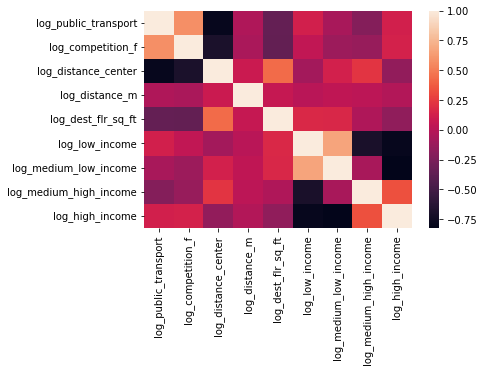

In [21]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = check_mul.corr()
sn.heatmap(corrMatrix, annot=False)
plt.savefig('correlation.png')
plt.show()

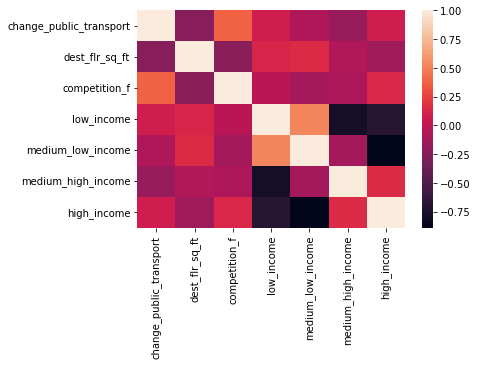

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = check_mul2.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

In [243]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7968 entries, 0 to 8544
Data columns (total 64 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   ID.x                                            7968 non-null   int64  
 1   dest_ID                                         7968 non-null   int64  
 2   dest_store                                      7968 non-null   object 
 3   orig_ID                                         7968 non-null   int64  
 4   orig_zip                                        7968 non-null   object 
 5   visit_each                                      7968 non-null   float64
 6   orig_centroid                                   7968 non-null   object 
 7   orig_pop                                        7968 non-null   int64  
 8   orig_family_income                              7968 non-null   int64  
 9   orig_x                                   

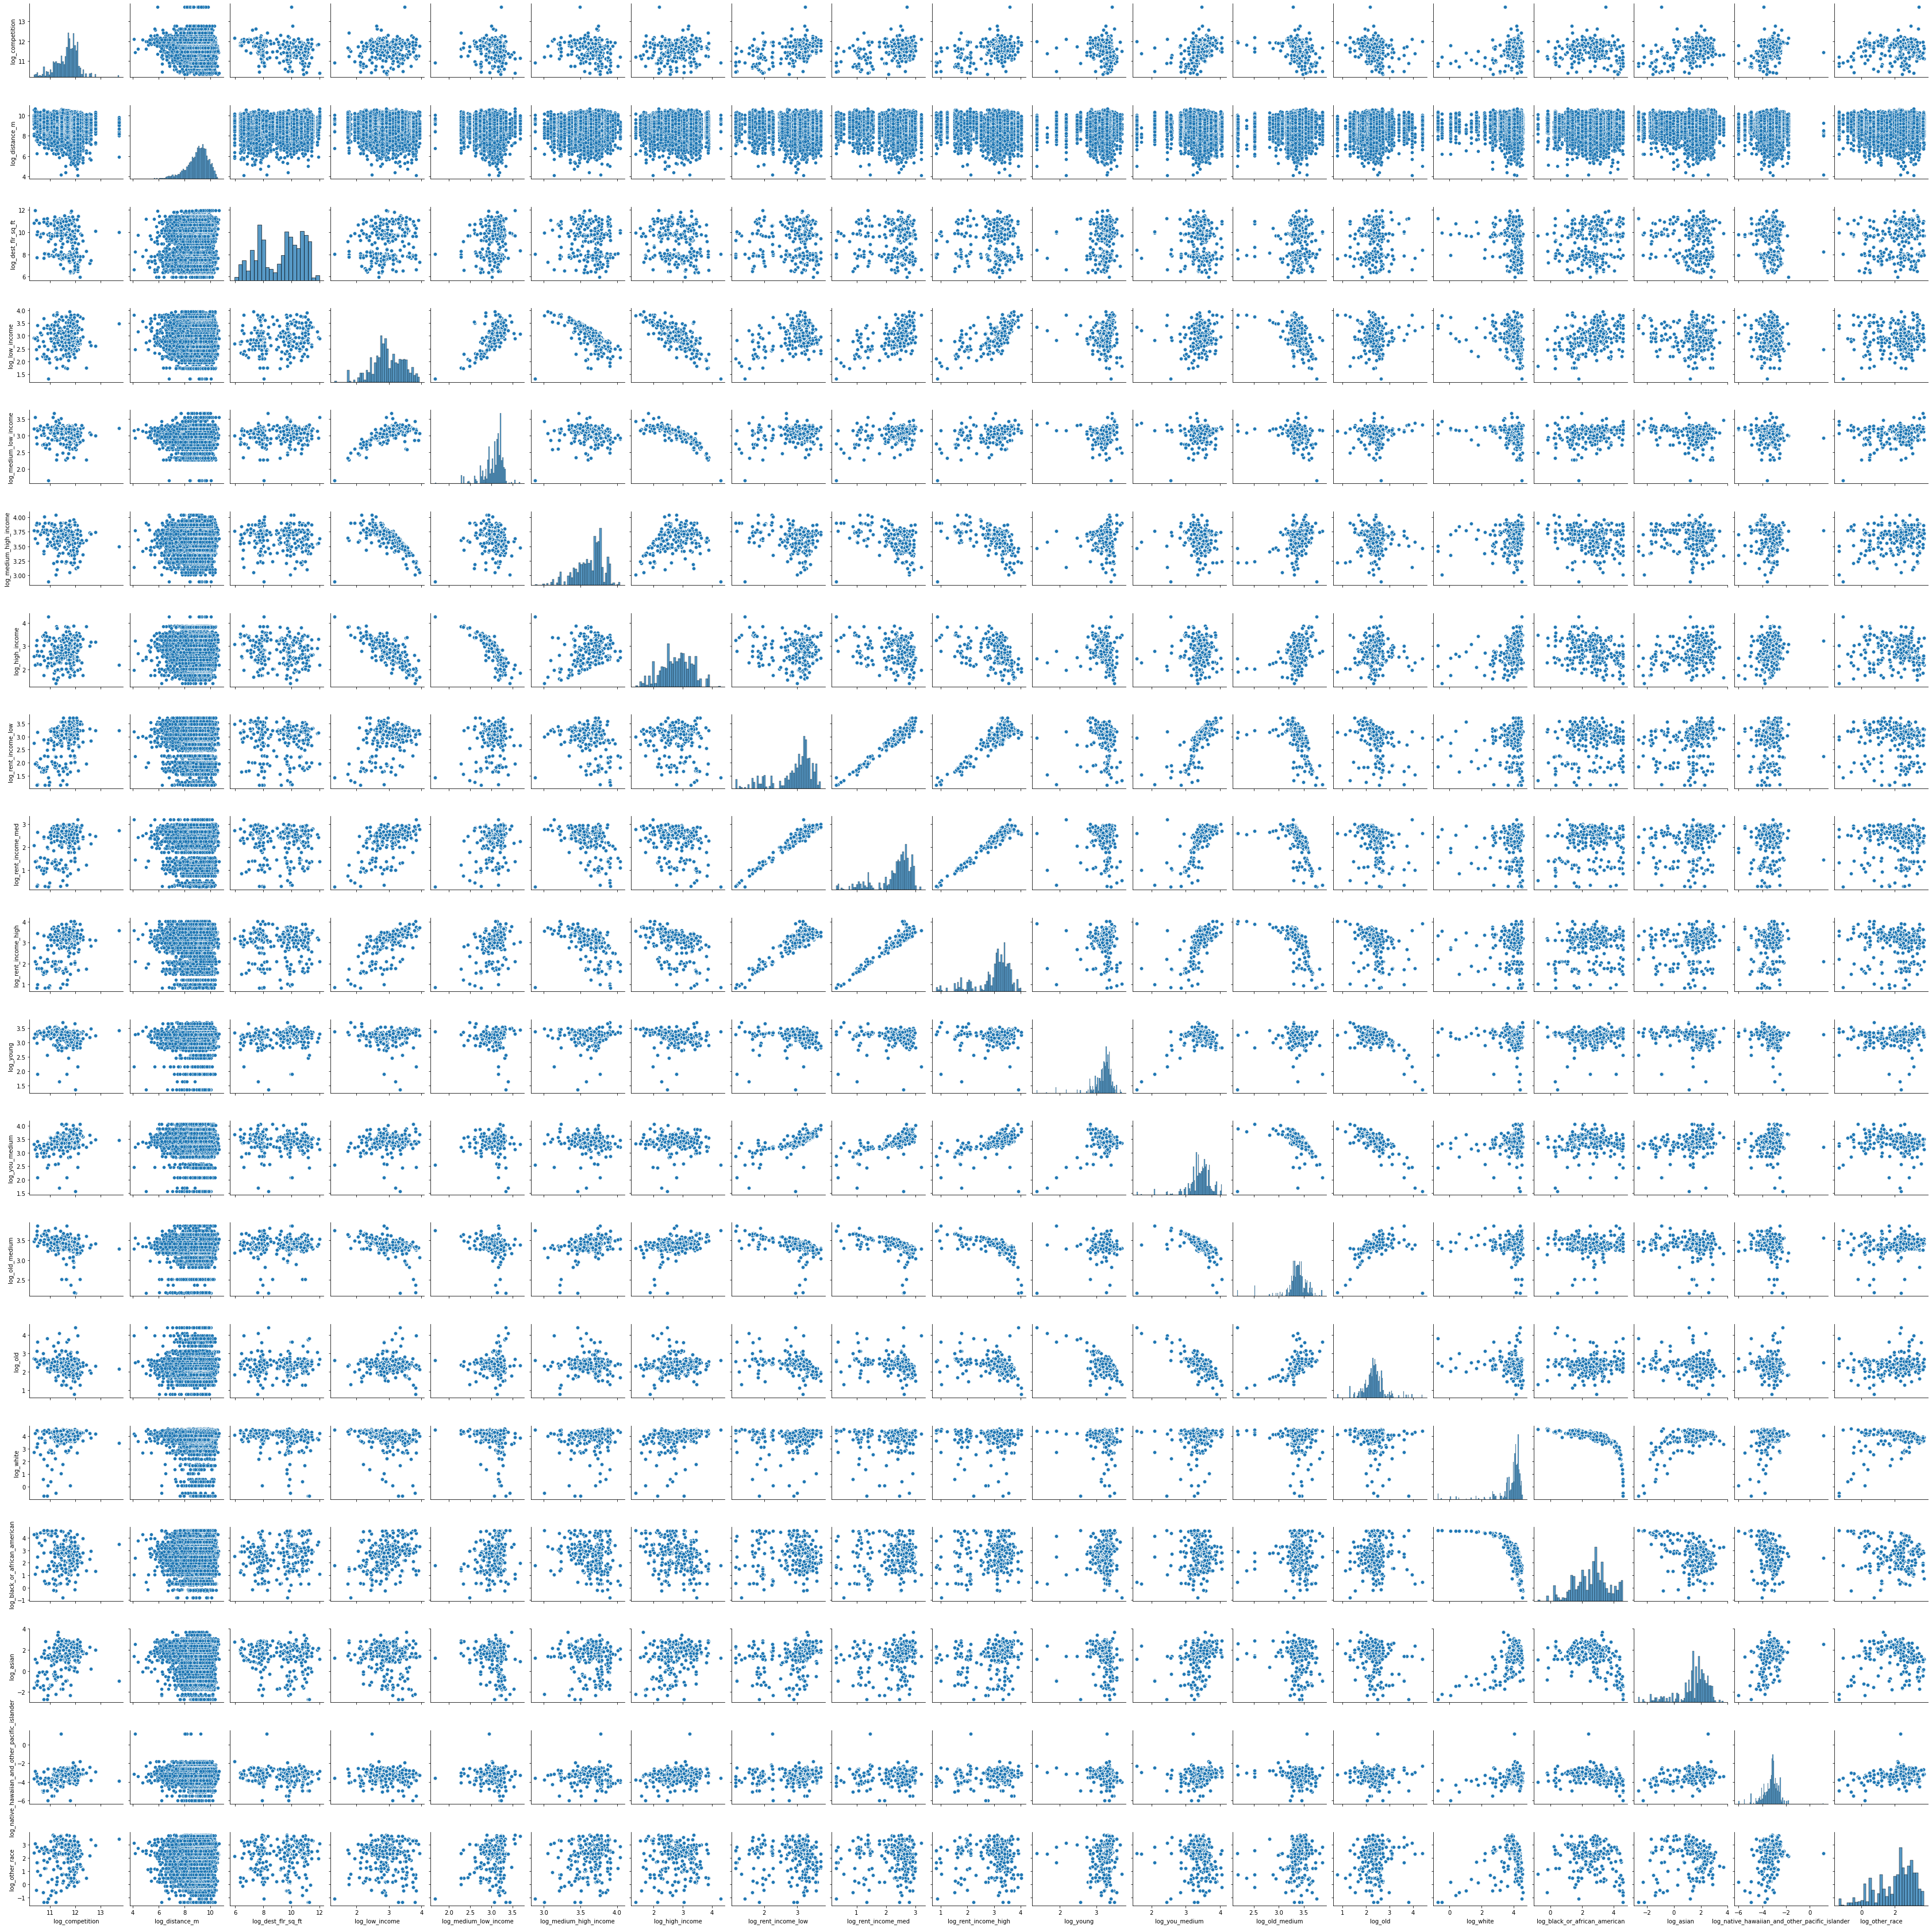

In [90]:
sns.pairplot(check_mul)

# Production constrained model

In [23]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'visit_each ~ orig_zip + log_public_transport+log_distance_center+ log_medium_low_income + log_medium_high_income + log_high_income+ log_dest_flr_sq_ft+ log_competition_f +log_distance_m-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=data_test, family=sm.families.Poisson()).fit()
#random ={"a": '0+log_rent_income_low'}
#model= PoissonBayesMixedGLM.from_formula(formula=formula,vc_formulas=random,data=data_model)
#result = model.fit_vb()
#let's have a look at it's summary
print(prodSim.summary())
#log_low_income + log_medium_low_income + log_medium_high_income + log_high_income
#log_white+log_black_or_african_american + log_asian + log_native_hawaiian_and_other_pacific_islander + log_other_race + log_two_or_more_races
#log_rent_income_low+log_rent_income_med+log_rent_income_high
#log_young+log_you_medium+log_old_medium+log_old

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                 7968
Model:                            GLM   Df Residuals:                     7959
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.6864e+07
Date:                Sat, 13 Aug 2022   Deviance:                   1.1365e+08
Time:                        13:22:54   Pearson chi2:                 1.59e+08
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
orig_zip                   0

In [24]:
predictions1 = prodSim.get_prediction()
predictions1_summary_frame = predictions1.summary_frame()
data_model["result"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(data_model["visit_each"], data_model["result"])
r2=CalcRMSE(data_model["visit_each"], data_model["result"])
print(r1,r2)

0.19836572558172488 36340.596


In [11]:
data_model[['result','visit_each']]

,result,visit_each
0,3874.0,4586.2225
1,22704.0,8718.3984
2,13037.0,4686.3120
3,6408.0,6174.1133
4,62292.0,64853.7564
...,...,...
7963,54456.0,12316.0808
7964,1825.0,1834.0062
7965,2510.0,432.3202
7966,3843.0,231.5800


In [221]:
generalproduction_new = data_model.pivot_table(values ="result", index="dest_store", columns = "orig_zip",
                            aggfunc=np.sum, margins=True)
generalproduction_new

orig_zip,60601,60602,60603,60604,60605,60606,60607,60608,60609,60610,...,60654,60655,60656,60657,60659,60660,60661,60707,60827,All
dest_store,,,,,,,,,,,,,,,,,,,,,
222-222@5pw-2r3-nwk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4068.0,NaN,NaN,NaN,NaN,NaN,NaN,14321.0,1205218.0
222-222@5pw-5zh-skf,NaN,258.0,NaN,NaN,2335.0,390.0,3332.0,4656.0,2286.0,11288.0,...,4723.0,NaN,NaN,17402.0,2453.0,3652.0,1694.0,19424.0,NaN,289800.0
222-222@5pw-5zp-9cq,NaN,NaN,127.0,NaN,2312.0,294.0,2821.0,5479.0,NaN,4897.0,...,NaN,NaN,2076.0,59232.0,11380.0,17191.0,1232.0,NaN,NaN,466678.0
222-222@5pw-5zp-mrk,NaN,NaN,NaN,NaN,892.0,NaN,NaN,NaN,NaN,1881.0,...,1073.0,NaN,NaN,21517.0,NaN,8812.0,NaN,NaN,NaN,206605.0
222-222@5pw-5zw-2ff,3812.0,1173.0,937.0,1613.0,171141.0,1336.0,10941.0,12848.0,6243.0,5200.0,...,6151.0,NaN,NaN,5326.0,NaN,2476.0,4314.0,NaN,NaN,367920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzy-222@5pw-5zg-2kz,NaN,NaN,NaN,NaN,NaN,NaN,5264.0,8483.0,4225.0,11066.0,...,NaN,NaN,NaN,44091.0,NaN,8278.0,2426.0,NaN,NaN,461180.0
zzy-223@5pw-699-k2k,522.0,122.0,NaN,NaN,1331.0,NaN,NaN,3369.0,NaN,2803.0,...,NaN,NaN,1193.0,21711.0,5065.0,6472.0,743.0,NaN,NaN,284050.0
zzy-223@5sb-8cv-wtv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1693.0,...,NaN,NaN,10561.0,NaN,NaN,NaN,NaN,NaN,NaN,107297.0


In [37]:
data_model["result"].dropna()

0        4564.0
1       25339.0
2       14808.0
3        7446.0
4       67468.0
         ...   
8540    84997.0
8541     3186.0
8542     4340.0
8543     6585.0
8544     2791.0
Name: result, Length: 7968, dtype: float64

# Production model for income clustering group

## data clean

In [255]:
income_cluster=pd.read_csv('data/cluster_income.csv')
income_cluster=income_cluster[['name','cluster_labels']]
income_cluster
data_test=data_model.copy()
#merge
data_test=pd.merge(data_test,income_cluster, left_on="dest_store", right_on="name", how="left")
data_test

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,log_you_medium,log_old_medium,log_old,log_low_income,log_medium_low_income,log_medium_high_income,log_high_income,result,name,cluster_labels
0,0,1,222-222@5pw-2r3-nwk,1,60613,4586.2225,"c(-87.6600560482455, 41.9544446976887)",48281,198630,-87.660056,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,1659.0,222-222@5pw-2r3-nwk,0
1,168,1,222-222@5pw-2r3-nwk,2,60620,8718.3984,"c(-87.6534303384955, 41.7395695585666)",72216,58886,-87.653430,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,20832.0,222-222@5pw-2r3-nwk,0
2,325,1,222-222@5pw-2r3-nwk,3,60621,4686.3120,"c(-87.6398183374013, 41.7759832343989)",35912,40393,-87.639818,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,5733.0,222-222@5pw-2r3-nwk,0
3,457,1,222-222@5pw-2r3-nwk,4,60623,6174.1133,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,4456.0,222-222@5pw-2r3-nwk,0
4,627,1,222-222@5pw-2r3-nwk,5,60628,64853.7564,"c(-87.6143668946616, 41.6916879141685)",72202,69223,-87.614367,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,86868.0,222-222@5pw-2r3-nwk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7963,6937,266,zzy-224@5pw-5zv-tvz,52,60604,12316.0808,"c(-87.6255900495128, 41.8783649825317)",570,307510,-87.625590,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,4756.0,zzy-224@5pw-5zv-tvz,2
7964,7228,266,zzy-224@5pw-5zv-tvz,54,60629,1834.0062,"c(-87.7127518885735, 41.7751962066305)",113916,65458,-87.712752,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,7221.0,zzy-224@5pw-5zv-tvz,2
7965,7383,266,zzy-224@5pw-5zv-tvz,55,60632,432.3202,"c(-87.7136446037417, 41.8117097554438)",91326,62374,-87.713645,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,5216.0,zzy-224@5pw-5zv-tvz,2
7966,7494,266,zzy-224@5pw-5zv-tvz,56,60653,231.5800,"c(-87.6103715857816, 41.8195286533947)",29908,73625,-87.610372,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,5820.0,zzy-224@5pw-5zv-tvz,2


In [308]:
cluster_lowvisit_highincome=data_test.loc[data_test['cluster_labels']==0]
cluster_lowvisit_highincome

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,log_you_medium,log_old_medium,log_old,log_low_income,log_medium_low_income,log_medium_high_income,log_high_income,result,name,cluster_labels
193,460,7,222-222@5pw-67m-q75,4,60623,7373.9079,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,12055.0,222-222@5pw-67m-q75,0
194,1811,7,222-222@5pw-67m-q75,15,60609,1751.3724,"c(-87.6553536020983, 41.812233942569)",64906,59072,-87.655354,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,3229.0,222-222@5pw-67m-q75,0
195,2416,7,222-222@5pw-67m-q75,19,60614,2346.8490,"c(-87.6508248489599, 41.922522084929)",66617,303735,-87.650825,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,8432.0,222-222@5pw-67m-q75,0
196,3363,7,222-222@5pw-67m-q75,25,60622,2871.9435,"c(-87.6842115419518, 41.9031259204398)",52548,175505,-87.684212,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,12234.0,222-222@5pw-67m-q75,0
197,3527,7,222-222@5pw-67m-q75,26,60625,2492.2221,"c(-87.7037232082866, 41.9721333277984)",78651,110761,-87.703723,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,8726.0,222-222@5pw-67m-q75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7651,7488,254,zzw-226@5pw-6d9-54v,56,60653,1568.7868,"c(-87.6103715857816, 41.8195286533947)",29908,73625,-87.610372,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,5507.0,zzw-226@5pw-6d9-54v,0
7652,7603,254,zzw-226@5pw-6d9-54v,57,60636,5968.6721,"c(-87.6689625043726, 41.7756530902845)",40916,49046,-87.668963,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,11961.0,zzw-226@5pw-6d9-54v,0
7653,7705,254,zzw-226@5pw-6d9-54v,58,60652,3052.3003,"c(-87.7120853668894, 41.7460571042666)",40959,88258,-87.712085,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,9259.0,zzw-226@5pw-6d9-54v,0
7654,7731,254,zzw-226@5pw-6d9-54v,59,60633,2063.2310,"c(-87.5576584476526, 41.6598212929941)",12927,74965,-87.557658,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,6114.0,zzw-226@5pw-6d9-54v,0


## build model

In [309]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'visit_each ~ orig_zip +log_distance_center+ log_public_transport+log_dest_flr_sq_ft+ log_competition +log_distance_m-1'
prodSim_cluster2 = smf.glm(formula = formula, data=cluster_lowvisit_highincome, family=sm.families.Poisson()).fit()
print(prodSim_cluster2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                  505
Model:                            GLM   Df Residuals:                      444
Model Family:                 Poisson   Df Model:                           60
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1875e+06
Date:                Mon, 25 Jul 2022   Deviance:                   4.3697e+06
Time:                        09:16:16   Pearson chi2:                 5.31e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
orig_zip[60602]         55.8011 

In [310]:
predictions1 = prodSim_cluster2.get_prediction()
predictions1_summary_frame = predictions1.summary_frame()
cluster_lowvisit_highincome["result"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(cluster_lowvisit_highincome["visit_each"], cluster_lowvisit_highincome["result"])
r2=CalcRMSE(cluster_lowvisit_highincome["visit_each"], cluster_lowvisit_highincome["result"])
print(r1,r2)

0.7276620716763014 22852.617


/var/folders/np/8s6_n_b16lx7rwgjy309j74m0000gn/T/ipykernel_3845/131824777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_lowvisit_highincome["result"] = round(predictions1_summary_frame["mean"],0)


# production model for race

In [311]:
race_cluster=pd.read_csv('data/cluster_race.csv')
race_cluster=race_cluster[['name','cluster_labels']]
race_cluster
data_test=data_model.copy()
#merge
data_test=pd.merge(data_test,race_cluster, left_on="dest_store", right_on="name", how="left")
data_test

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,log_you_medium,log_old_medium,log_old,log_low_income,log_medium_low_income,log_medium_high_income,log_high_income,result,name,cluster_labels
0,0,1,222-222@5pw-2r3-nwk,1,60613,4586.2225,"c(-87.6600560482455, 41.9544446976887)",48281,198630,-87.660056,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,1655.0,222-222@5pw-2r3-nwk,2
1,168,1,222-222@5pw-2r3-nwk,2,60620,8718.3984,"c(-87.6534303384955, 41.7395695585666)",72216,58886,-87.653430,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,20888.0,222-222@5pw-2r3-nwk,2
2,325,1,222-222@5pw-2r3-nwk,3,60621,4686.3120,"c(-87.6398183374013, 41.7759832343989)",35912,40393,-87.639818,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,5805.0,222-222@5pw-2r3-nwk,2
3,457,1,222-222@5pw-2r3-nwk,4,60623,6174.1133,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,4547.0,222-222@5pw-2r3-nwk,2
4,627,1,222-222@5pw-2r3-nwk,5,60628,64853.7564,"c(-87.6143668946616, 41.6916879141685)",72202,69223,-87.614367,...,3.425998,3.351995,2.249266,3.422731,3.221198,3.556319,2.224539,86628.0,222-222@5pw-2r3-nwk,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7963,6937,266,zzy-224@5pw-5zv-tvz,52,60604,12316.0808,"c(-87.6255900495128, 41.8783649825317)",570,307510,-87.625590,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,4783.0,zzy-224@5pw-5zv-tvz,3
7964,7228,266,zzy-224@5pw-5zv-tvz,54,60629,1834.0062,"c(-87.7127518885735, 41.7751962066305)",113916,65458,-87.712752,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,6928.0,zzy-224@5pw-5zv-tvz,3
7965,7383,266,zzy-224@5pw-5zv-tvz,55,60632,432.3202,"c(-87.7136446037417, 41.8117097554438)",91326,62374,-87.713645,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,5035.0,zzy-224@5pw-5zv-tvz,3
7966,7494,266,zzy-224@5pw-5zv-tvz,56,60653,231.5800,"c(-87.6103715857816, 41.8195286533947)",29908,73625,-87.610372,...,3.407965,3.413439,2.191730,2.787511,2.963731,3.639667,3.269824,5639.0,zzy-224@5pw-5zv-tvz,3


In [321]:
race=data_test.loc[data_test['cluster_labels']==0]
race

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,log_you_medium,log_old_medium,log_old,log_low_income,log_medium_low_income,log_medium_high_income,log_high_income,result,name,cluster_labels
193,460,7,222-222@5pw-67m-q75,4,60623,7373.9079,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,12059.0,222-222@5pw-67m-q75,0
194,1811,7,222-222@5pw-67m-q75,15,60609,1751.3724,"c(-87.6553536020983, 41.812233942569)",64906,59072,-87.655354,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,3254.0,222-222@5pw-67m-q75,0
195,2416,7,222-222@5pw-67m-q75,19,60614,2346.8490,"c(-87.6508248489599, 41.922522084929)",66617,303735,-87.650825,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,8374.0,222-222@5pw-67m-q75,0
196,3363,7,222-222@5pw-67m-q75,25,60622,2871.9435,"c(-87.6842115419518, 41.9031259204398)",52548,175505,-87.684212,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,12166.0,222-222@5pw-67m-q75,0
197,3527,7,222-222@5pw-67m-q75,26,60625,2492.2221,"c(-87.7037232082866, 41.9721333277984)",78651,110761,-87.703723,...,3.078233,3.639427,2.551006,2.207175,2.736962,3.788046,3.443299,8493.0,222-222@5pw-67m-q75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7651,7488,254,zzw-226@5pw-6d9-54v,56,60653,1568.7868,"c(-87.6103715857816, 41.8195286533947)",29908,73625,-87.610372,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,5643.0,zzw-226@5pw-6d9-54v,0
7652,7603,254,zzw-226@5pw-6d9-54v,57,60636,5968.6721,"c(-87.6689625043726, 41.7756530902845)",40916,49046,-87.668963,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,12121.0,zzw-226@5pw-6d9-54v,0
7653,7705,254,zzw-226@5pw-6d9-54v,58,60652,3052.3003,"c(-87.7120853668894, 41.7460571042666)",40959,88258,-87.712085,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,9294.0,zzw-226@5pw-6d9-54v,0
7654,7731,254,zzw-226@5pw-6d9-54v,59,60633,2063.2310,"c(-87.5576584476526, 41.6598212929941)",12927,74965,-87.557658,...,2.446974,3.408945,3.801538,3.409276,3.334107,3.505357,2.129025,6175.0,zzw-226@5pw-6d9-54v,0


In [322]:
formula = 'visit_each ~ orig_zip + log_distance_center+log_public_transport+log_dest_flr_sq_ft+ log_competition +log_distance_m-1'
prodSim_cluster3 = smf.glm(formula = formula, data=race, family=sm.families.Poisson()).fit()
print(prodSim_cluster3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                  505
Model:                            GLM   Df Residuals:                      444
Model Family:                 Poisson   Df Model:                           60
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1875e+06
Date:                Mon, 25 Jul 2022   Deviance:                   4.3697e+06
Time:                        09:32:49   Pearson chi2:                 5.31e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
orig_zip[60602]         55.8011 

In [323]:
predictions2 = prodSim_cluster3.get_prediction()
predictions2_summary_frame = predictions2.summary_frame()
race["result"] = round(predictions2_summary_frame["mean"],0)
r1=CalcRSquared(race["visit_each"], race["result"])
r2=CalcRMSE(race["visit_each"], race["result"])
print(r1,r2)

0.7276620716763014 22852.617


/var/folders/np/8s6_n_b16lx7rwgjy309j74m0000gn/T/ipykernel_3845/1837427513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race["result"] = round(predictions2_summary_frame["mean"],0)


# Try attraction constrained model

In [151]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'visit_each ~ dest_store + log_orig_pop+log_orig_family_income + log_distance_m-1'
#run a production constrained sim
attrSim = smf.glm(formula = attr_form, data=data_new, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                 8577
Model:                            GLM   Df Residuals:                     8307
Model Family:                 Poisson   Df Model:                          269
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.7744e+07
Date:                Sun, 10 Jul 2022   Deviance:                   5.5403e+07
Time:                        19:33:08   Pearson chi2:                 7.97e+07
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
dest_store

In [159]:
predictions2 = attrSim.get_prediction()
predictions1_summary_frame = predictions2.summary_frame()
data_model["result_a"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(data_model["visit_each"], data_model["result_a"])
r2=CalcRMSE(data_model["visit_each"], data_model["result_a"])
print(r1,r2)

0.7701001274761133 17481.174


In [170]:
generalattraction_new = data_model.pivot_table(values ="result_a", index="dest_store", columns = "orig_zip",
                            aggfunc=np.sum, margins=True)
generalattraction_new

orig_zip,60601,60602,60603,60604,60605,60606,60607,60608,60609,60610,...,60654,60655,60656,60657,60659,60660,60661,60707,60827,All
dest_store,,,,,,,,,,,,,,,,,,,,,
222-222@5pw-2r3-nwk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13597.0,NaN,NaN,NaN,NaN,NaN,NaN,14790.0,711373.0
222-222@5pw-5zh-skf,NaN,623.0,NaN,NaN,5623.0,1306.0,8240.0,12029.0,5389.0,41164.0,...,10052.0,NaN,NaN,38086.0,4440.0,5573.0,4111.0,26300.0,NaN,602179.0
222-222@5pw-5zp-9cq,NaN,NaN,159.0,NaN,3961.0,689.0,4919.0,10168.0,NaN,12128.0,...,NaN,NaN,3240.0,98823.0,15973.0,20368.0,2091.0,NaN,NaN,732594.0
222-222@5pw-5zp-mrk,NaN,NaN,NaN,NaN,928.0,NaN,NaN,NaN,NaN,2828.0,...,958.0,NaN,NaN,21724.0,NaN,6441.0,NaN,NaN,NaN,184056.0
222-222@5pw-5zw-2ff,13187.0,2482.0,1485.0,2249.0,422613.0,3860.0,23309.0,28316.0,12546.0,14634.0,...,10708.0,NaN,NaN,8791.0,NaN,2980.0,8892.0,NaN,NaN,775104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzy-222@5pw-5zg-2kz,NaN,NaN,NaN,NaN,NaN,NaN,13547.0,22990.0,10453.0,40888.0,...,NaN,NaN,NaN,103113.0,NaN,13416.0,6093.0,NaN,NaN,1074051.0
zzy-223@5pw-699-k2k,545.0,77.0,NaN,NaN,846.0,NaN,NaN,2327.0,NaN,2574.0,...,NaN,NaN,690.0,13096.0,2599.0,2776.0,468.0,NaN,NaN,164777.0
zzy-223@5sb-8cv-wtv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.0,...,NaN,NaN,1936.0,NaN,NaN,NaN,NaN,NaN,NaN,19549.0


In [160]:
data_model

,ID.x,dest_ID,dest_store,orig_ID,orig_zip,visit_each,orig_centroid,orig_pop,orig_family_income,orig_x,...,log_medium_high_income,log_high_income,log_young,log_you_medium,log_old_medium,log_old,log_rent_income_low,log_rent_income_med,log_rent_income_high,result
0,0,1,222-222@5pw-2r3-nwk,1,60613,4586.2225,"c(-87.6600560482455, 41.9544446976887)",48281,198630,-87.660056,...,3.556319,2.224539,3.384737,3.425998,3.351995,2.249266,3.166075,2.653164,3.429493,4607.0
1,168,1,222-222@5pw-2r3-nwk,2,60620,8718.3984,"c(-87.6534303384955, 41.7395695585666)",72216,58886,-87.653430,...,3.556319,2.224539,3.384737,3.425998,3.351995,2.249266,3.166075,2.653164,3.429493,26984.0
2,325,1,222-222@5pw-2r3-nwk,3,60621,4686.3120,"c(-87.6398183374013, 41.7759832343989)",35912,40393,-87.639818,...,3.556319,2.224539,3.384737,3.425998,3.351995,2.249266,3.166075,2.653164,3.429493,15503.0
3,457,1,222-222@5pw-2r3-nwk,4,60623,6174.1133,"c(-87.7169144752057, 41.848458001064)",92108,48013,-87.716914,...,3.556319,2.224539,3.384737,3.425998,3.351995,2.249266,3.166075,2.653164,3.429493,7627.0
4,627,1,222-222@5pw-2r3-nwk,5,60628,64853.7564,"c(-87.6143668946616, 41.6916879141685)",72202,69223,-87.614367,...,3.556319,2.224539,3.384737,3.425998,3.351995,2.249266,3.166075,2.653164,3.429493,74064.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8540,6937,266,zzy-224@5pw-5zv-tvz,52,60604,12316.0808,"c(-87.6255900495128, 41.8783649825317)",570,307510,-87.625590,...,3.639667,3.269824,3.288752,3.407965,3.413439,2.191730,2.925130,2.254060,2.964985,91987.0
8541,7228,266,zzy-224@5pw-5zv-tvz,54,60629,1834.0062,"c(-87.7127518885735, 41.7751962066305)",113916,65458,-87.712752,...,3.639667,3.269824,3.288752,3.407965,3.413439,2.191730,2.925130,2.254060,2.964985,3103.0
8542,7383,266,zzy-224@5pw-5zv-tvz,55,60632,432.3202,"c(-87.7136446037417, 41.8117097554438)",91326,62374,-87.713645,...,3.639667,3.269824,3.288752,3.407965,3.413439,2.191730,2.925130,2.254060,2.964985,4268.0
8543,7494,266,zzy-224@5pw-5zv-tvz,56,60653,231.5800,"c(-87.6103715857816, 41.8195286533947)",29908,73625,-87.610372,...,3.639667,3.269824,3.288752,3.407965,3.413439,2.191730,2.925130,2.254060,2.964985,6552.0


# Spatial interaction model for Convenience store and SuperMarket

In [3]:
# import store type data
store_type=pd.read_csv('data/Store_type.csv')
store_type=store_type[['fk_sgplaces','sub_category']]
store_type
convenience_store=store_type[store_type['sub_category'].str.contains('Convenience Stores')]
convenience_store
supermarket_store=store_type[store_type['sub_category'].str.contains('Supermarkets and Other Grocery')]
#supermarket_store
convenience_store

,fk_sgplaces,sub_category
924,22x-222@5pw-67m-gx5,Convenience Stores
925,zzw-222@5pw-6cd-k9f,Convenience Stores
926,zzw-223@5pw-2r9-ks5,Convenience Stores
927,23d-222@5pw-6cn-bff,Convenience Stores
928,zzw-222@5pw-6fk-9xq,Convenience Stores
...,...,...
1177,zzy-222@5pw-69k-d9z,Convenience Stores
1178,zzw-222@5pw-6rc-835,Convenience Stores
1179,zzw-226@5pw-5zw-kmk,Convenience Stores
1180,224-223@5pw-5zw-6ff,Convenience Stores


In [4]:
data_model=pd.read_csv('GLMM_final_check.csv')

In [5]:
# merge data
conv_m=pd.merge(convenience_store, data_model, left_on='fk_sgplaces',right_on='dest_store',how='inner')
conv_m
super_m=pd.merge(supermarket_store,data_model, left_on='fk_sgplaces',right_on='dest_store',how='inner')

In [15]:
super_m

,fk_sgplaces_x,sub_category,Unnamed: 0.1,fk_sgplaces_y,competition_f,Unnamed: 0,ID.x,dest_ID,dest_store,orig_ID,...,log_young,log_you_medium,log_old_medium,log_old,log_low_income,log_medium_low_income,log_medium_high_income,log_high_income,result,log_competition_f
0,zzw-222@5pw-6bv-9fz,Supermarkets and Other Grocery (except Conveni...,5753,zzw-222@5pw-6bv-9fz,0.118898,6112,277,187,zzw-222@5pw-6bv-9fz,2,...,3.486854,3.336895,3.305303,2.319286,3.794961,3.439986,3.011891,1.387872,2241.0,-2.129489
1,zzw-222@5pw-6bv-9fz,Supermarkets and Other Grocery (except Conveni...,5754,zzw-222@5pw-6bv-9fz,0.118898,6113,418,187,zzw-222@5pw-6bv-9fz,3,...,3.486854,3.336895,3.305303,2.319286,3.794961,3.439986,3.011891,1.387872,2695.0,-2.129489
2,zzw-222@5pw-6bv-9fz,Supermarkets and Other Grocery (except Conveni...,5755,zzw-222@5pw-6bv-9fz,0.118898,6114,581,187,zzw-222@5pw-6bv-9fz,4,...,3.486854,3.336895,3.305303,2.319286,3.794961,3.439986,3.011891,1.387872,4040.0,-2.129489
3,zzw-222@5pw-6bv-9fz,Supermarkets and Other Grocery (except Conveni...,5756,zzw-222@5pw-6bv-9fz,0.118898,6115,713,187,zzw-222@5pw-6bv-9fz,5,...,3.486854,3.336895,3.305303,2.319286,3.794961,3.439986,3.011891,1.387872,3606.0,-2.129489
4,zzw-222@5pw-6bv-9fz,Supermarkets and Other Grocery (except Conveni...,5757,zzw-222@5pw-6bv-9fz,0.118898,6116,1219,187,zzw-222@5pw-6bv-9fz,9,...,3.486854,3.336895,3.305303,2.319286,3.794961,3.439986,3.011891,1.387872,2006.0,-2.129489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,224-222@5pw-69x-rhq,Supermarkets and Other Grocery (except Conveni...,2076,224-222@5pw-69x-rhq,0.126363,2303,5799,65,224-222@5pw-69x-rhq,41,...,3.555062,3.463233,3.288029,1.677097,2.157559,2.897568,4.045679,2.778819,NaN,-2.068594
4679,224-222@5pw-69x-rhq,Supermarkets and Other Grocery (except Conveni...,2077,224-222@5pw-69x-rhq,0.126363,2304,5799,65,224-222@5pw-69x-rhq,42,...,3.555062,3.463233,3.288029,1.677097,2.157559,2.897568,4.045679,2.778819,NaN,-2.068594
4680,224-222@5pw-69x-rhq,Supermarkets and Other Grocery (except Conveni...,2078,224-222@5pw-69x-rhq,0.126363,2305,6129,65,224-222@5pw-69x-rhq,44,...,3.555062,3.463233,3.288029,1.677097,2.157559,2.897568,4.045679,2.778819,NaN,-2.068594
4681,224-222@5pw-69x-rhq,Supermarkets and Other Grocery (except Conveni...,2079,224-222@5pw-69x-rhq,0.126363,2306,6303,65,224-222@5pw-69x-rhq,46,...,3.555062,3.463233,3.288029,1.677097,2.157559,2.897568,4.045679,2.778819,NaN,-2.068594


In [16]:
conv_m.to_csv('convenience_store_glm.csv')
super_m.to_csv('supermarket_glm.csv')

In [12]:
formula = 'visit_each ~ orig_zip + orig_zip +log_dest_flr_sq_ft + log_distance_center + log_public_transport+log_competition_f+log_medium_low_income+log_medium_high_income+log_high_income+log_distance_m-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=conv_m, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                 3285
Model:                            GLM   Df Residuals:                     3276
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1193e+07
Date:                Sun, 14 Aug 2022   Deviance:                   2.2355e+07
Time:                        21:33:44   Pearson chi2:                 3.32e+07
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
orig_zip                   0

In [14]:
predictions1 = prodSim.get_prediction()
predictions1_summary_frame = predictions1.summary_frame()
conv_m["result"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(conv_m["visit_each"], conv_m["result"])
r2=CalcRMSE(conv_m["visit_each"], conv_m["result"])
print(r1,r2)

0.21013134328173738 13536.532


In [80]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'visit_each ~ dest_store + log_orig_pop+log_orig_family_income + log_distance_m-1'
#run a production constrained sim
attrSim = smf.glm(formula = attr_form, data=conv_m, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                 3285
Model:                            GLM   Df Residuals:                     3178
Model Family:                 Poisson   Df Model:                          106
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.8927e+06
Date:                Sat, 09 Jul 2022   Deviance:                   1.1754e+07
Time:                        17:30:11   Pearson chi2:                 1.52e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
dest_store

In [81]:
predictions2 = attrSim.get_prediction()
predictions1_summary_frame = predictions2.summary_frame()
conv_m["result"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(conv_m["visit_each"], conv_m["result"])
r2=CalcRMSE(conv_m["visit_each"], conv_m["result"])
print(r1,r2)

0.7135878223307841 8180.893


# Spatial Interaction model for City center and Suburb

In [374]:
#Import
Suburb= pd.read_csv('data/sub_urb.csv')
Suburb=Suburb[['fk_sgplaces']]
City_cen=pd.read_csv('data/selected_cbd.csv')
City_cen=City_cen[['fk_sgplaces']]

In [375]:
# merge data
sub_m=pd.merge(Suburb, data_model, left_on='fk_sgplaces',right_on='dest_store',how='inner')
city_m=pd.merge(City_cen,data_model, left_on='fk_sgplaces',right_on='dest_store',how='inner')

In [378]:
formula = 'visit_each ~ orig_zip +log_rent_income_low+log_rent_income_med+log_rent_income_high+log_young+log_you_medium+log_old_medium+log_old+log_low_income + log_medium_low_income + log_medium_high_income + log_high_income+
log_white+log_black_or_african_american + log_asian
+  log_dest_flr_sq_ft+ log_competition +log_distance_m-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=city_m, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                 3912
Model:                            GLM   Df Residuals:                     3837
Model Family:                 Poisson   Df Model:                           74
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2937e+07
Date:                Mon, 11 Jul 2022   Deviance:                   2.5835e+07
Time:                        09:59:17   Pearson chi2:                 3.24e+07
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
orig_zip[60601

In [379]:
predictions1 = prodSim.get_prediction()
predictions1_summary_frame = predictions1.summary_frame()
city_m["result"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(city_m["visit_each"], city_m["result"])
r2=CalcRMSE(city_m["visit_each"], city_m["result"])
print(r1,r2)

0.5977270403629401 19334.192


In [365]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'visit_each ~ dest_store + log_orig_pop+log_orig_family_income + log_distance_m-1'
#run a production constrained sim
attrSim = smf.glm(formula = attr_form, data=sub_m, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visit_each   No. Observations:                 2021
Model:                            GLM   Df Residuals:                     1937
Model Family:                 Poisson   Df Model:                           83
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.8888e+06
Date:                Mon, 11 Jul 2022   Deviance:                   1.9757e+07
Time:                        09:37:14   Pearson chi2:                 3.01e+07
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
dest_store

In [366]:
predictions2 = attrSim.get_prediction()
predictions1_summary_frame = predictions2.summary_frame()
sub_m["result_a"] = round(predictions1_summary_frame["mean"],0)
r1=CalcRSquared(sub_m["visit_each"], sub_m["result_a"])
r2=CalcRMSE(sub_m["visit_each"], sub_m["result_a"])
print(r1,r2)

0.730490030144707 23928.825
